<a href="https://colab.research.google.com/github/Baipzix/BC_Beetle/blob/main/TimeSeriesAnalysis_MODIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# start and end date
# date_s_e=['2020-01-01', '2023-12-31']

# range of year
roy = 17

# select the band
datalist = ['LST_Day_1km', 'NDVI', 'EVI']
data_i = 'EVI'

scale_n = 500
# lon and lat of one site
p_lon, p_lat = -125, 56
# lon and lat of list of sites
# for example: list_lon,  list_lat = [-125.1, -125.1, -125.2], [56.1, 56.2, 56.3]
list_lon,  list_lat = [], []



In [ ]:
import ee
import pandas as pd
import altair as alt
import numpy as np
import folium
import datetime
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline


import ipyleaflet
import ipywidgets
from google.colab import files

In [ ]:
# prompt: try initialize the ee library and the project is bcforesthealth. if doesn't work, authenticate ee and initialize it again

try:
  ee.Initialize()
except Exception as e:
  print(e)
  # Authenticate and initialize Earth Engine
  ee.Authenticate()
  ee.Initialize(project='ee-bcforesthealth')
  print('Authentication successful')


In [ ]:

roy =roy *-1
today = ee.Date(pd.to_datetime('today'))
date_range = ee.DateRange(today.advance(roy, 'year'), today)
d_start=date_range.start().getInfo()
d_start=pd.to_datetime(d_start['value'], unit='ms').year

d_end = date_range.end().getInfo()
d_end=pd.to_datetime(d_end['value'], unit='ms').year

date_s_e =[str(d_start), str(d_end)]

modislist = ['MODIS/061/MOD11A1', 'MODIS/061/MOD13Q1']

if data_i == 'LST_Day_1km':
  modis = modislist[0]
  modis_band = 'LST_Day_1km'
else:
  modis = modislist[1]
  modis_band = data_i


resource_region = ee.FeatureCollection('projects/ee-bcforesthealth/assets/ResourceRegion')
# Filter the feature collection based on the 'Cl1' attribute
filtered_region = resource_region.filter(ee.Filter.eq('ORG_UNIT', rr_name))

imgs_dr = ee.ImageCollection(modis).filter(ee.Filter.date(date_range))
imgs_st = imgs_dr.select(modis_band) # image collection of land surface temperature
#imgs_clip = imgs_st.map(lambda image: image.clip(filtered_region)) #display

# Time Series Analysis

In [ ]:
if len(list_lon)>0:
  p_lon = list_lon[0]
  p_lat = list_lat[0]

p_geom =ee.Geometry.Point(p_lon, p_lat)

In [ ]:
p_info = imgs_st.getRegion(p_geom, scale_n).getInfo()

In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

def min_max_scaling(value):
    min_val = -2000
    max_val = 10000
    new_min = -1
    new_max = 1
    scaled_value = ((value - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min
    return scaled_value

In [ ]:
p_df = ee_array_to_df(p_info,[data_i])

if data_i == 'LST_Day_1km':
  p_df['LST_Day_1km'] = p_df['LST_Day_1km'].apply(t_modis_to_celsius)
elif data_i == 'NDVI':
  p_df['NDVI'] = p_df['NDVI'].apply(lambda x: min_max_scaling(x))
elif data_i == 'EVI':
  p_df['EVI'] = p_df['EVI'].apply(lambda x: min_max_scaling(x))



p_df.head()

,time,datetime,EVI
0,1174521600000,2007-03-22,-0.526000
1,1175904000000,2007-04-07,-0.507000
2,1177286400000,2007-04-23,-0.625500
3,1178668800000,2007-05-09,-0.594667
4,1180051200000,2007-05-25,-0.521833


In [ ]:
# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(p_df['time'].apply(float))


## Secondly, extract y values  from the dfs.

y_data = np.asanyarray(p_df[data_i].apply(float))


## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params, params_covariance = optimize.curve_fit(
    fit_func, x_data, y_data, p0=[lst0, delta_lst, tau, phi])


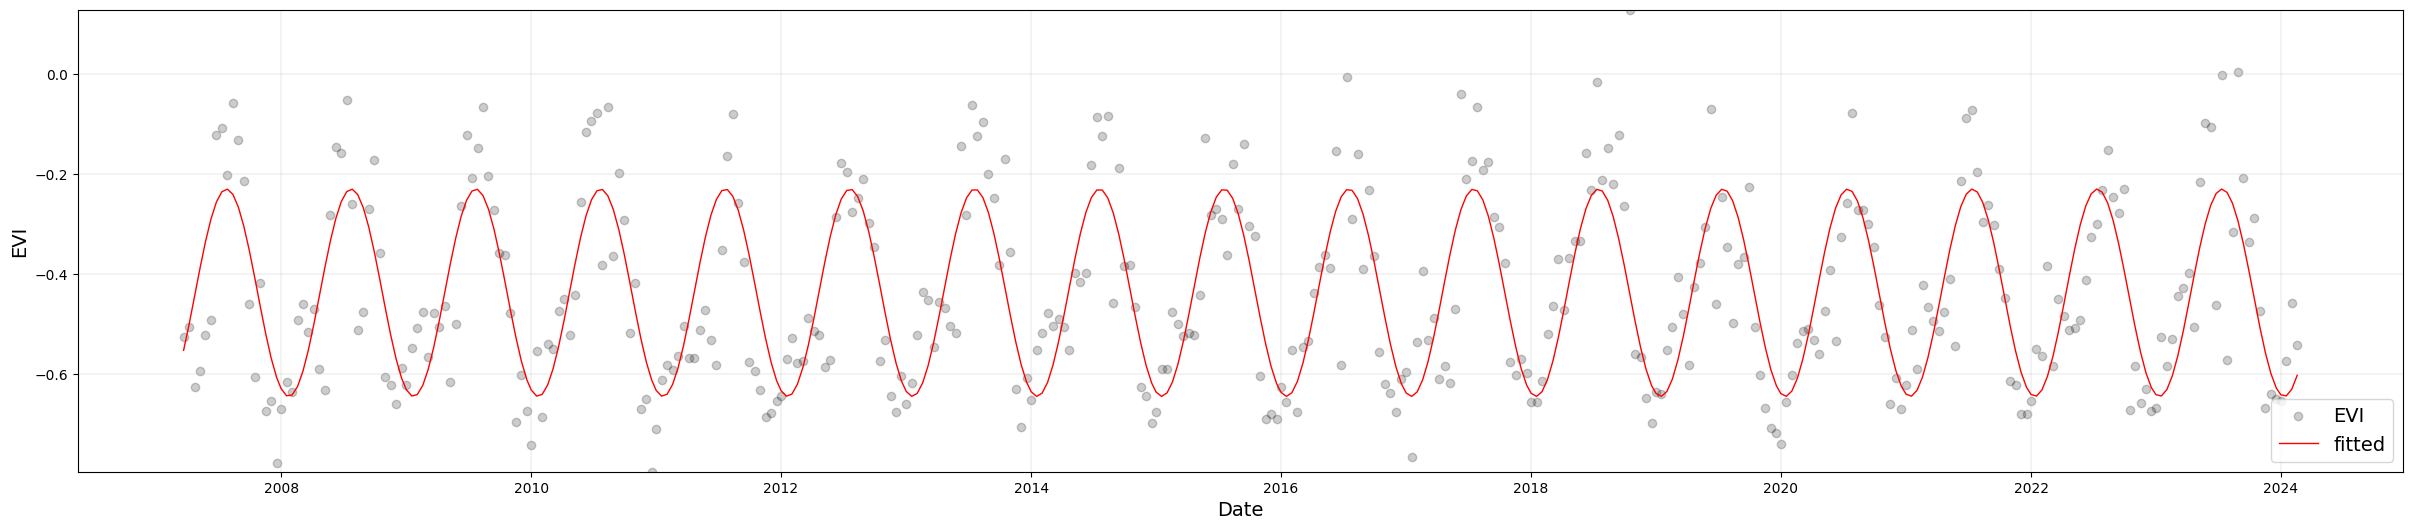

In [ ]:
# Subplots.
fig, ax = plt.subplots(figsize=(30, 6))

# Add scatter plots.
ax.scatter(p_df['datetime'], p_df[data_i],
           c='black', alpha=0.2, label= data_i)


# Add fitting curves.
ax.plot(p_df['datetime'],
        fit_func(x_data, params[0], params[1], params[2], params[3]),
        label='fitted', color='red', lw=1)


# Add some parameters.
#ax.set_title('Surface Value', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(data_i, fontsize=14)
ymin, ymax = y_data.min(), y_data.max()

ax.set_ylim(ymin, ymax)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [ ]:
ps_df = pd.DataFrame()

for i, (p_lon, p_lat) in enumerate(zip(list_lon, list_lat)):
    p_geom = ee.Geometry.Point(p_lon, p_lat)
    p_info = imgs_st.getRegion(p_geom, scale_n).getInfo()
    p_df = ee_array_to_df(p_info, [data_i])
    p_df['lon'] = p_lon
    p_df['lat'] = p_lat

    if data_i == 'LST_Day_1km':
        p_df['LST_Day_1km'] = p_df['LST_Day_1km'].apply(t_modis_to_celsius)
    elif data_i == 'NDVI' or data_i == 'EVI':
        p_df[data_i] = p_df[data_i].apply(lambda x: min_max_scaling(x))

    if ps_df.empty:
        ps_df = p_df.copy()
    else:
        ps_df = pd.concat([ps_df, p_df], ignore_index=True)

# Reset the index after appending multiple dataframes
ps_df.reset_index(drop=True, inplace=True)
ps_df.head()


In [ ]:
if ps_df.size ==0:
  dfile = p_df
else:
  dfile = ps_df

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['time'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

p_df = add_date_info(dfile)
p_df.head()

,time,datetime,EVI,Timestamp,Year,Month,Day,DOY
0,1174521600000,2007-03-22,-0.526000,2007-03-22,2007,3,22,81
1,1175904000000,2007-04-07,-0.507000,2007-04-07,2007,4,7,97
2,1177286400000,2007-04-23,-0.625500,2007-04-23,2007,4,23,113
3,1178668800000,2007-05-09,-0.594667,2007-05-09,2007,5,9,129
4,1180051200000,2007-05-25,-0.521833,2007-05-25,2007,5,25,145


In [ ]:
now = datetime.datetime.now()
formatted_time = now.strftime("%Y%m%d_%H%M%S")
dfname = f"TS_{data_i}_{formatted_time}.csv"

# Save the dataframe to a CSV file
p_df.to_csv(dfname, sep=',', encoding='utf-8')

# Download the CSV file to your local machine
files.download(dfname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dfchart = p_df

if data_i == 'LST_Day_1km':
  alt.Chart(dfchart).mark_rect().encode(
      x='Year:O',
      y='Month:O',
      color=alt.Color(
          'mean(LST_Day_1km):Q', scale=alt.Scale(scheme='redblue', domain=(dfchart[data_i].min(), dfchart[data_i].max()))),
      tooltip=[
          alt.Tooltip('Year:O', title='Year'),
          alt.Tooltip('Month:O', title='Month'),
          alt.Tooltip('mean(LST_Day_1km):Q', title='LST')
      ]).properties(width=600, height=300) \
      .display()

elif data_i == 'NDVI':
  alt.Chart(dfchart).mark_rect().encode(
      x='Year:O',
      y='Month:O',
      color=alt.Color(
          'mean(NDVI):Q', scale=alt.Scale(scheme='redblue', domain=(dfchart[data_i].min(), dfchart[data_i].max()))),
      tooltip=[
          alt.Tooltip('Year:O', title='Year'),
          alt.Tooltip('Month:O', title='Month'),
          alt.Tooltip('mean(NDVI):Q', title='NDVI')
      ]).properties(width=600, height=300) \
      .display()

elif data_i == 'EVI':
  alt.Chart(dfchart).mark_rect().encode(
      x='Year:O',
      y='Month:O',
      color=alt.Color(
          'mean(EVI):Q', scale=alt.Scale(scheme='redblue', domain=(dfchart[data_i].min(), dfchart[data_i].max()))),
      tooltip=[
          alt.Tooltip('Year:O', title='Year'),
          alt.Tooltip('Month:O', title='Month'),
          alt.Tooltip('mean(EVI):Q', title='EVI')
      ]).properties(width=600, height=300) \
      .display()

alt.Chart(...)